In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Set up graphs
matplotlib.rcParams.update({'font.size': 11})

In [3]:
#Define the autocollimator zero position in pixels and the resolution setting of the PiCamera
zero_x = 848.54
zero_y = 540.77
resolution = np.array((1640.0, 1232.0))

In [4]:
def load_dataset(filename):
    """Load a calibration/measurement uncertainty dataset into two dataframes. One dataframe contains the yaw data, the other dataframe contains the pitch data"""
    with open(r'..\Data\{}'.format(filename), 'r') as f:
        data = f.readlines()
        for line_no, line in enumerate(data):
            if line == 'Yaw angle calibration\n':
                startx = line_no
            elif line == 'Pitch angle calibration\n':
                starty = line_no

    if startx < starty:
        dfx = pd.read_csv(r'..\Data\{}'.format(filename), delimiter = ',', skipinitialspace = True,
                          skiprows = startx + 1, nrows = starty - startx - 2)
        dfy = pd.read_csv(r'..\Data\{}'.format(filename), delimiter = ',', skipinitialspace = True,
                          skiprows = starty + 1)
    elif starty < startx:
        dfy = pd.read_csv(r'..\Data\{}'.format(filename), delimiter = ',', skipinitialspace = True,
                          skiprows = starty + 1, nrows = startx - starty - 2)
        dfx = pd.read_csv(r'..\Data\{}'.format(filename), delimiter = ',', skipinitialspace = True,
                          skiprows = startx + 1)

    dfx.dropna(inplace = True)
    dfy.dropna(inplace = True)
    dfx = dfx.astype('float64')
    dfy = dfy.astype('float64')
    dfx.reset_index(drop = True, inplace = True)
    dfy.reset_index(drop = True, inplace = True)
    return dfx, dfy

In [5]:
def residual(dfx, dfy, calibration, resolution, zero_x, zero_y):
    """Return the difference between the measured autocollimator angle and the expected mirror angle"""
    #The yaw dataset consists of 3 repeated runs
    nx = int(dfx.shape[0] / 3)
    mirror = dfx['Angle (arcsec)'].copy().values
    x = dfx['Peak x position (px)'].copy().values
    y = dfx['Peak y position (px)'].copy().values
    #For each repeated run, centre the peak spot positions and the corresponding mirror angles about the data point closest to the autocollimator zero position
    for i in range(3):
        zero_position = np.argmin(np.abs(x[i * nx:(i + 1) * nx] - zero_x))
        zero_position = i * nx + zero_position
        mirror[i * nx:(i + 1) * nx] = mirror[i * nx:(i + 1) * nx] - mirror[zero_position]
        x[i * nx:(i + 1) * nx] = x[i * nx:(i + 1) * nx] - x[zero_position]
        y[i * nx:(i + 1) * nx] = y[i * nx:(i + 1) * nx] - y[zero_position]
    dfx.insert(3, 'Mirror angle (arcsec)', mirror)
    dfx.insert(4, 'Zeroed x position (px)', x)
    dfx.insert(5, 'Zeroed y position (px)', y)
    #Reduce the 2D displacements to 1D, adopt the sign of the centred x positions
    dfx['Displacement (px)'] = np.sign(dfx['Zeroed x position (px)']) * np.sqrt(dfx['Zeroed x position (px)']**2 + dfx['Zeroed y position (px)']**2)
    #Convert the displacements to angle using the autocollimator calibration factor
    dfx['Autocollimator angle (arcsec)'] = dfx['Displacement (px)'] / calibration
    #Calculate the difference between the measured autocollimator angles and the expected mirror angles
    dfx['Differences (arcsec)'] = dfx['Autocollimator angle (arcsec)'] - dfx['Mirror angle (arcsec)']
    #Generate a seperate dataframe that only contains data points collected using the middle thrid of the camera sensor
    dfx_middle = dfx[(dfx['Peak x position (px)'] > resolution[0] / 3.0) & (dfx['Peak x position (px)'] < 2.0 * resolution[0] / 3.0)]

    #The pitch data is processed by following the same method as above
    ny = int(dfy.shape[0] / 3)
    mirror = dfy['Angle (arcsec)'].copy().values
    x = dfy['Peak x position (px)'].copy().values
    y = dfy['Peak y position (px)'].copy().values
    for i in range(3):
        zero_position = np.argmin(np.abs(y[i * ny:(i + 1) * ny] - zero_y))
        zero_position = i * ny + zero_position
        mirror[i * ny:(i + 1) * ny] = mirror[i * ny:(i + 1) * ny] - mirror[zero_position]
        x[i * ny:(i + 1) * ny] = x[i * ny:(i + 1) * ny] - x[zero_position]
        y[i * ny:(i + 1) * ny] = y[i * ny:(i + 1) * ny] - y[zero_position]
    dfy.insert(3, 'Mirror angle (arcsec)', mirror)
    dfy.insert(4, 'Zeroed x position (px)', x)
    dfy.insert(5, 'Zeroed y position (px)', y)
    #Reduce the 2D displacements to 1D, adopt the sign of the centred y positions
    dfy['Displacement (px)'] = np.sign(dfy['Zeroed y position (px)']) * np.sqrt(dfy['Zeroed x position (px)']**2 + dfy['Zeroed y position (px)']**2)
    dfy['Autocollimator angle (arcsec)'] = dfy['Displacement (px)'] / calibration
    dfy['Differences (arcsec)'] = dfy['Autocollimator angle (arcsec)'] - dfy['Mirror angle (arcsec)']
    dfy_middle = dfy[(dfy['Peak y position (px)'] > resolution[1] / 3.0) & (dfy['Peak y position (px)'] < 2.0 * resolution[1] / 3.0)]
    return (dfx['Mirror angle (arcsec)'].copy().values, dfx_middle['Mirror angle (arcsec)'].copy().values,
            dfy['Mirror angle (arcsec)'].copy().values, dfy_middle['Mirror angle (arcsec)'].copy().values,
            dfx['Differences (arcsec)'].copy().values, dfx_middle['Differences (arcsec)'].copy().values,
            dfy['Differences (arcsec)'].copy().values, dfy_middle['Differences (arcsec)'].copy().values)

## Calibration

In [6]:
#Load calibration dataset
dfx, dfy = load_dataset('Calibration\processed_data_20210609_120156.txt')

#Yaw calibration was repeated 3 times
nx = int(dfx.shape[0] / 3)
mirror = dfx['Angle (arcsec)'].copy().values
x = dfx['Peak x position (px)'].copy().values
y = dfx['Peak y position (px)'].copy().values
#For each calibration run, center the calibration points about the point closest to the autocollimator zero position
for i in range(3):
    zero_position = np.argmin(np.abs(x[i * nx:(i + 1) * nx] - zero_x))
    zero_position = i * nx + zero_position
    mirror[i * nx:(i + 1) * nx] = mirror[i * nx:(i + 1) * nx] - mirror[zero_position]
    x[i * nx:(i + 1) * nx] = x[i * nx:(i + 1) * nx] - x[zero_position]
    y[i * nx:(i + 1) * nx] = y[i * nx:(i + 1) * nx] - y[zero_position]
dfx.insert(3, 'Mirror angle (arcsec)', mirror)
dfx.insert(4, 'Zeroed x position (px)', x)
dfx.insert(5, 'Zeroed y position (px)', y)
#Reduce the 2D displacements to 1D, adopt the sign of the centred x position
dfx['Displacement (px)'] = np.sign(dfx['Zeroed x position (px)']) * np.sqrt(dfx['Zeroed x position (px)']**2 + dfx['Zeroed y position (px)']**2)
#Generate a seperate dataframe that only contains calibration points collected using the middle thrid of the camera sensor
dfx_middle = dfx[(dfx['Peak x position (px)'] > resolution[0] / 3.0) & (dfx['Peak x position (px)'] < 2.0 * resolution[0] / 3.0)]

#Pitch calibration data is processed by following the same method as above
ny = int(dfy.shape[0] / 3)
mirror = dfy['Angle (arcsec)'].copy().values
x = dfy['Peak x position (px)'].copy().values
y = dfy['Peak y position (px)'].copy().values
for i in range(3):
    zero_position = np.argmin(np.abs(y[i * ny:(i + 1) * ny] - zero_y))
    zero_position = i * ny + zero_position
    mirror[i * ny:(i + 1) * ny] = mirror[i * ny:(i + 1) * ny] - mirror[zero_position]
    x[i * ny:(i + 1) * ny] = x[i * ny:(i + 1) * ny] - x[zero_position]
    y[i * ny:(i + 1) * ny] = y[i * ny:(i + 1) * ny] - y[zero_position]
dfy.insert(3, 'Mirror angle (arcsec)', mirror)
dfy.insert(4, 'Zeroed x position (px)', x)
dfy.insert(5, 'Zeroed y position (px)', y)
#Reduce the 2D displacements to 1D, adopt the sign of the centred y position
dfy['Displacement (px)'] = np.sign(dfy['Zeroed y position (px)']) * np.sqrt(dfy['Zeroed x position (px)']**2 + dfy['Zeroed y position (px)']**2)
dfy_middle = dfy[(dfy['Peak y position (px)'] > resolution[1] / 3.0) & (dfy['Peak y position (px)'] < 2.0 * resolution[1] / 3.0)]

#Calibrate yaw and pitch by performing a linear fit on the calibration points collected using the middle thrid of the camera sensor. The autocollimator calibration factor is the average of the yaw and pitch calibration factors
calibration_x, cov_x = np.polyfit(dfx_middle['Mirror angle (arcsec)'], dfx_middle['Displacement (px)'], 1, cov = True)
calibration_y, cov_y = np.polyfit(dfy_middle['Mirror angle (arcsec)'], dfy_middle['Displacement (px)'], 1, cov = True)
calibration_err_x = np.sqrt(cov_x[0, 0])
calibration_err_y = np.sqrt(cov_y[0, 0])
calibration = (calibration_x[0] + calibration_y[0]) / 2.0
calibration_err = np.abs((calibration_x[0] - calibration_y[0]) / calibration)
print('Yaw calibration factor: {} +- {:.2g} px/arcsec\n'
      'Pitch calibration factor: {} +- {:.2g} px/arcsec\n'
      'Autocollimator calibration factor: {} +- {:.2g} px/arcsec'
      .format(calibration_x[0], calibration_err_x, calibration_y[0], calibration_err_y, calibration, calibration_err))

Yaw calibration factor: 0.2220837828684558 +- 6.6e-05 px/arcsec
Pitch calibration factor: 0.22178592187937746 +- 6.3e-05 px/arcsec
Autocollimator calibration factor: 0.22193485237391664 +- 0.0013 px/arcsec


In [7]:
#Convert measured displacements to autocollimator angles, and calculate the difference between the measured autocollimator angles and the expected mirror angles
dfx['Autocollimator angle (arcsec)'] = dfx['Displacement (px)'] / calibration
dfx['Differences (arcsec)'] = dfx['Autocollimator angle (arcsec)'] - dfx['Mirror angle (arcsec)']

dfy['Autocollimator angle (arcsec)'] = dfy['Displacement (px)'] / calibration
dfy['Differences (arcsec)'] = dfy['Autocollimator angle (arcsec)'] - dfy['Mirror angle (arcsec)']

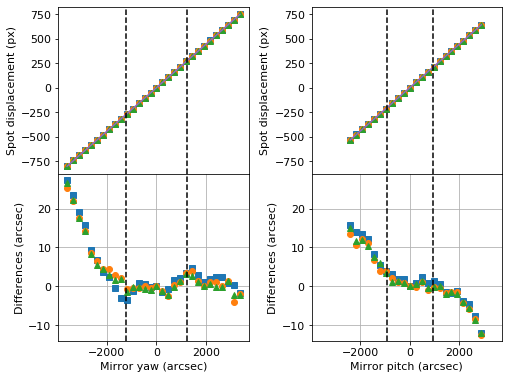

In [8]:
#Plot the calibration data, the calibration fit, and the differences calculated above. The region in between the dotted lines indicate the middle third of the camera sensor
fig, ax = plt.subplots(2, 2, figsize = (7.20, 5.40), sharex = True)
ax[0, 0].set_ylabel('Spot displacement (px)')
ax[0, 1].set_ylabel('Spot displacement (px)')
ax[1, 0].set_ylabel('Differences (arcsec)')
ax[1, 1].set_ylabel('Differences (arcsec)')
ax[1, 0].set_xlabel('Mirror yaw (arcsec)')
ax[1, 1].set_xlabel('Mirror pitch (arcsec)')
ax[1, 0].grid()
ax[1, 1].grid()

marker= ['s', 'o', '^']

for i in range(3):
    ax[0, 0].plot(dfx['Mirror angle (arcsec)'].iloc[i * nx:(i + 1) * nx],
                  dfx['Displacement (px)'].iloc[i * nx:(i + 1) * nx], marker = marker[i], linestyle = '')
    ax[0, 1].plot(dfy['Mirror angle (arcsec)'].iloc[i * ny:(i + 1) * ny],
                  dfy['Displacement (px)'].iloc[i * ny:(i + 1) * ny], marker = marker[i], linestyle = '')

ax[0, 0].plot(dfx['Mirror angle (arcsec)'].iloc[0:nx],
              calibration * dfx['Mirror angle (arcsec)'].iloc[0:nx], linestyle = '-', color = '#9467bd')
ax[0, 1].plot(dfy['Mirror angle (arcsec)'].iloc[0:ny],
              calibration * dfy['Mirror angle (arcsec)'].iloc[0:ny], linestyle = '-', color = '#9467bd')

for i in range(3):
    ax[1, 0].plot(dfx['Mirror angle (arcsec)'].iloc[i * nx:(i + 1) * nx],
                  dfx['Differences (arcsec)'].iloc[i * nx:(i + 1) * nx], marker = marker[i], linestyle = '')
    ax[1, 1].plot(dfy['Mirror angle (arcsec)'].iloc[i * ny:(i + 1) * ny],
                  dfy['Differences (arcsec)'].iloc[i * ny:(i + 1) * ny], marker = marker[i], linestyle = '')

ax[0, 0].axvline(-resolution[0] / (calibration * 6.0), color = 'k', linestyle = '--')
ax[0, 0].axvline(resolution[0] / (calibration * 6.0), color = 'k', linestyle = '--')
ax[1, 0].axvline(-resolution[0] / (calibration * 6.0), color = 'k', linestyle = '--')
ax[1, 0].axvline(resolution[0] / (calibration * 6.0), color = 'k', linestyle = '--')
ax[0, 1].axvline(-resolution[1] / (calibration * 6.0), color = 'k', linestyle = '--')
ax[0, 1].axvline(resolution[1] / (calibration * 6.0), color = 'k', linestyle = '--')
ax[1, 1].axvline(-resolution[1] / (calibration * 6.0), color = 'k', linestyle = '--')
ax[1, 1].axvline(resolution[1] / (calibration * 6.0), color = 'k', linestyle = '--')

ymin1, ymax1 = ax[0, 0].get_ylim()
ymin2, ymax2 = ax[0, 1].get_ylim()
ymin = np.min([ymin1, ymin2])
ymax = np.max([ymax1, ymax2])
ax[0, 0].set_ylim(ymin, ymax)
ax[0, 1].set_ylim(ymin, ymax)
ymin1, ymax1 = ax[1, 0].get_ylim()
ymin2, ymax2 = ax[1, 1].get_ylim()
ymin = np.min([ymin1, ymin2])
ymax = np.max([ymax1, ymax2])
ax[1, 0].set_ylim(ymin, ymax)
ax[1, 1].set_ylim(ymin, ymax)
xmin1, xmax1 = ax[1, 0].get_xlim()
xmin2, xmax2 = ax[1, 1].get_xlim()
xmin = np.min([xmin1, xmin2])
xmax = np.max([xmax1, xmax2])
ax[1, 0].set_xlim(xmin, xmax)
ax[1, 1].set_xlim(xmin, xmax)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
plt.savefig('calibration.pdf')
plt.show()

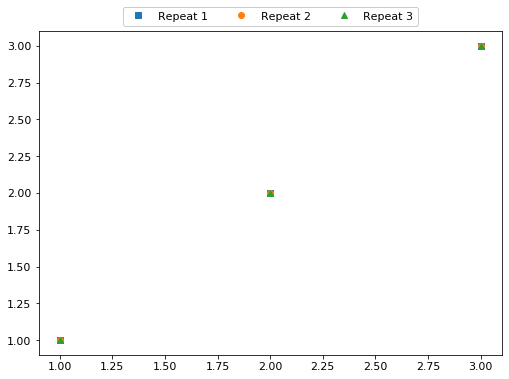

In [9]:
#Generate legends
fig, ax = plt.subplots(1, 1, figsize = (7.20, 5.40))

temp_x = np.array([1, 2, 3])
temp_y = np.array([1, 2, 3])

ax.plot(temp_x, temp_y, marker = 's', linestyle = '', label = 'Repeat 1')
ax.plot(temp_x, temp_y, marker = 'o', linestyle = '', label = 'Repeat 2')
ax.plot(temp_x, temp_y, marker = '^', linestyle = '', label = 'Repeat 3')

ax.legend(loc = 'lower center', bbox_to_anchor = (0.5, 1), ncol = 3, framealpha = 1)

plt.tight_layout()
plt.savefig('calibration_legend.pdf')
plt.show()

## Measurement uncertainty

In [10]:
#Filename of datasets collected at different working distances
filename = ['Calibration\processed_data_20210609_120156.txt',
            'Measurement_uncertainty\processed_data_20210726_121731.txt',
            'Measurement_uncertainty\processed_data_20210803_134514.txt',
            'Measurement_uncertainty\processed_data_20210805_160259.txt',
            'Measurement_uncertainty\processed_data_20210806_130807.txt']
#Working distances at which the above datasets are collected (in the same order)
wd = np.array([25, 23, 102, 372, 247])

date = []
mirror_angle = []
differences = []

#Load each dataset and calculate the difference between the measured autocollimator angles and the expected mirror angles
for i, f in enumerate(filename):
    date.append(f.split('_')[-2])
    dfx, dfy = load_dataset(f)
    mirror_x, mirror_x_middle, mirror_y, mirror_y_middle, diff_x, diff_x_middle, diff_y, diff_y_middle = residual(dfx, dfy, calibration, resolution, zero_x, zero_y)
    mirror_angle.append([mirror_x, mirror_x_middle, mirror_y, mirror_y_middle])
    differences.append([diff_x, diff_x_middle, diff_y, diff_y_middle])

mirror_angle = np.array(mirror_angle)
differences = np.array(differences)

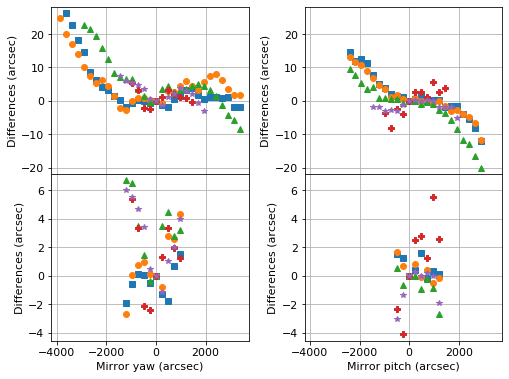

In [11]:
#Plot the differences calculated above for each working distance, the top graphs show all data points over the entire measurement range, the bottom graphs show the data points collected using the middle third of the camera sensor
fig, ax = plt.subplots(2, 2, figsize = (7.20, 5.40), sharex = True)
ax[0, 0].set_ylabel('Differences (arcsec)')
ax[0, 1].set_ylabel('Differences (arcsec)')
ax[1, 0].set_ylabel('Differences (arcsec)')
ax[1, 1].set_ylabel('Differences (arcsec)')
ax[1, 0].set_xlabel('Mirror yaw (arcsec)')
ax[1, 1].set_xlabel('Mirror pitch (arcsec)')
ax[0, 0].grid()
ax[0, 1].grid()
ax[1, 0].grid()
ax[1, 1].grid()

marker= ['s', 'o', '^', 'P', '*']

for i in range(np.shape(wd)[0]):
    ax[0, 0].plot(np.mean(np.split(mirror_angle[i, 0], 3), axis = 0),
                  np.mean(np.split(differences[i, 0], 3), axis = 0), marker = marker[i], linestyle = '')
    ax[1, 0].plot(np.mean(np.split(mirror_angle[i, 1], 3), axis = 0),
                  np.mean(np.split(differences[i, 1], 3), axis = 0), marker = marker[i], linestyle = '')
    ax[0, 1].plot(np.mean(np.split(mirror_angle[i, 2], 3), axis = 0),
                  np.mean(np.split(differences[i, 2], 3), axis = 0), marker = marker[i], linestyle = '')
    ax[1, 1].plot(np.mean(np.split(mirror_angle[i, 3], 3), axis = 0),
                  np.mean(np.split(differences[i, 3], 3), axis = 0), marker = marker[i], linestyle = '')

ymin1, ymax1 = ax[0, 0].get_ylim()
ymin2, ymax2 = ax[0, 1].get_ylim()
ymin = np.min([ymin1, ymin2])
ymax = np.max([ymax1, ymax2])
ax[0, 0].set_ylim(ymin, ymax)
ax[0, 1].set_ylim(ymin, ymax)
ymin1, ymax1 = ax[1, 0].get_ylim()
ymin2, ymax2 = ax[1, 1].get_ylim()
ymin = np.min([ymin1, ymin2])
ymax = np.max([ymax1, ymax2])
ax[1, 0].set_ylim(ymin, ymax)
ax[1, 1].set_ylim(ymin, ymax)
xmin1, xmax1 = ax[1, 0].get_xlim()
xmin2, xmax2 = ax[1, 1].get_xlim()
xmin = np.min([xmin1, xmin2])
xmax = np.max([xmax1, xmax2])
ax[1, 0].set_xlim(xmin, xmax)
ax[1, 1].set_xlim(xmin, xmax)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
plt.savefig('measurement_uncertainty.pdf')
plt.show()

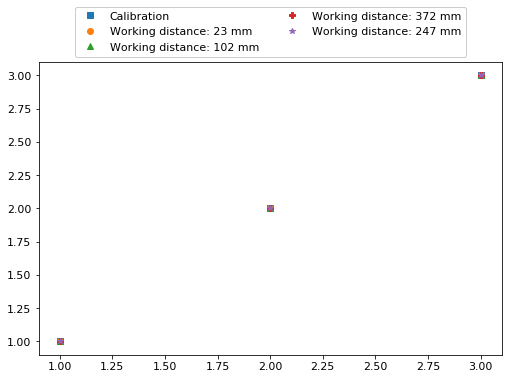

In [12]:
#Generate legends
fig, ax = plt.subplots(1, 1, figsize = (7.20, 5.40))

temp_x = np.array([1, 2, 3])
temp_y = np.array([1, 2, 3])

ax.plot(temp_x, temp_y, marker = 's', linestyle = '', label = 'Calibration')
ax.plot(temp_x, temp_y, marker = 'o', linestyle = '', label = 'Working distance: 23 mm')
ax.plot(temp_x, temp_y, marker = '^', linestyle = '', label = 'Working distance: 102 mm')
ax.plot(temp_x, temp_y, marker = 'P', linestyle = '', label = 'Working distance: 372 mm')
ax.plot(temp_x, temp_y, marker = '*', linestyle = '', label = 'Working distance: 247 mm')

ax.legend(loc = 'lower center', bbox_to_anchor = (0.5, 1), ncol = 2, framealpha = 1)

plt.tight_layout()
plt.savefig('measurement_uncertainty_legend.pdf')
plt.show()

In [13]:
#For each working distance, calculate the measurement uncertainty over the maximum measurement range, and the measurement uncertainty over the middle third of the camera sensor. The measurement uncertainty is quantified by the standard deviation of the differences plotted in the graph above
differences_std_x = np.zeros(np.shape(wd)[0])
differences_std_x_middle = np.zeros(np.shape(wd)[0])
differences_std_y = np.zeros(np.shape(wd)[0])
differences_std_y_middle = np.zeros(np.shape(wd)[0])
measurement_range_x = np.zeros(np.shape(wd)[0])
measurement_range_x_middle = np.zeros(np.shape(wd)[0])
measurement_range_y = np.zeros(np.shape(wd)[0])
measurement_range_y_middle = np.zeros(np.shape(wd)[0])

for i in range(np.shape(wd)[0]):
    differences_std_x[i] = np.std(differences[i, 0], ddof = 1)
    differences_std_x_middle[i] = np.std(differences[i, 1], ddof = 1)
    differences_std_y[i] = np.std(differences[i, 2], ddof = 1)
    differences_std_y_middle[i] = np.std(differences[i, 3], ddof = 1)

    #Find the maximum measurement range and the measurement range corresponding to the middle third of the camera sensor. The dataset is checked to make sure these measurement ranges are consistant between repeated runs
    mirror_yaw = np.split(mirror_angle[i, 0], 3)
    mirror_pitch = np.split(mirror_angle[i, 2], 3)
    if (mirror_yaw[0] == mirror_yaw[1]).all() & (mirror_yaw[1] == mirror_yaw[2]).all() & (mirror_pitch[0] == mirror_pitch[1]).all() & (mirror_pitch[1] == mirror_pitch[2]).all():
        measurement_range_x[i] = mirror_yaw[0].max() - mirror_yaw[0].min()
        measurement_range_y[i] = mirror_pitch[0].max() - mirror_pitch[0].min()

    mirror_yaw = np.split(mirror_angle[i, 1], 3)
    mirror_pitch = np.split(mirror_angle[i, 3], 3)
    if (mirror_yaw[0] == mirror_yaw[1]).all() & (mirror_yaw[1] == mirror_yaw[2]).all() & (mirror_pitch[0] == mirror_pitch[1]).all() & (mirror_pitch[1] == mirror_pitch[2]).all():
        measurement_range_x_middle[i] = mirror_yaw[0].max() - mirror_yaw[0].min()
        measurement_range_y_middle[i] = mirror_pitch[0].max() - mirror_pitch[0].min()

In [14]:
#Generate a dataframe to show the measurement uncertainty over the middle third of the camera sensor at different working distances
data = {'Working distance (mm)': wd,
        'Yaw measurement range (arcsec)': measurement_range_x_middle,
        'Yaw residual standard deviation (arcsec)': differences_std_x_middle,
        'Pitch measurement range (arcsec)': measurement_range_y_middle,
        'Pitch residual standard deviation (arcsec)': differences_std_y_middle}
table_middle = pd.DataFrame(data)
table_middle = table_middle.round(6)
table_middle.sort_values(by = ['Working distance (mm)'], inplace = True)
table_middle.reset_index(drop = True, inplace = True)
table_middle

Working distance (mm)  Yaw measurement range (arcsec)  \
0                     23                     2165.780466   
1                     25                     2165.780466   
2                    102                     2165.780466   
3                    247                     2165.780466   
4                    372                     1925.138192   

   Yaw residual standard deviation (arcsec)  Pitch measurement range (arcsec)  \
0                                  2.409126                       1684.495918   
1                                  1.199428                       1684.495918   
2                                  2.834458                       1684.495918   
3                                  2.400752                       1684.495918   
4                                  2.585598                       1684.495918   

   Pitch residual standard deviation (arcsec)  
0                                    1.240463  
1                                    0.837477  
2                                    1.787019  
3                                    2.733774  
4                                    3.852267

In [15]:
#Generate a dataframe to show the measurement uncertainty over the maximum measurement range at different working distances
data = {'Working distance (mm)': wd,
        'Yaw measurement range (arcsec)': measurement_range_x,
        'Yaw residual standard deviation (arcsec)': differences_std_x,
        'Pitch measurement range (arcsec)': measurement_range_y,
        'Pitch residual standard deviation (arcsec)': differences_std_y}
table_full = pd.DataFrame(data)
table_full = table_full.round(6)
table_full.sort_values(by = ['Working distance (mm)'], inplace = True)
table_full.reset_index(drop = True, inplace = True)
table_full

Working distance (mm)  Yaw measurement range (arcsec)  \
0                     23                     7219.268219   
1                     25                     6978.625945   
2                    102                     6256.699123   
3                    247                     3368.991835   
4                    372                     2406.422740   

   Yaw residual standard deviation (arcsec)  Pitch measurement range (arcsec)  \
0                                  6.392620                       5294.130027   
1                                  7.237487                       5294.130027   
2                                  7.658812                       5294.130027   
3                                  2.855872                       3368.991835   
4                                  2.401722                       2406.422740   

   Pitch residual standard deviation (arcsec)  
0                                    6.553138  
1                                    6.517066  
2                                    7.557861  
3                                    3.047261  
4                                    4.728164